# Analysis of Multivariate Scoring Functions for Automatic Unbiased earning to Rank

## FIrstly, we need to clone the ULTRA repo, which we create for Unbiased learning to rank. You may need to follow the instruction in https://github.com/ULTR-Community/ULTRA to install ULTRA.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json
import os
import re 
from collections import defaultdict
from utils.process import process,extract_mse
from scipy import stats
import pandas as pd

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
!git clone https://github.com/ULTR-Community/ULTRA.git

Cloning into 'ULTRA'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 1680 (delta 94), reused 82 (delta 48), pack-reused 1516
Receiving objects: 100% (1680/1680), 11.77 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (1101/1101), done.


## The benchmark we test of our method are Yahoo set 1 and Istella\-s. First we need to follow the instruction to download and preprocess the data accordingly. You may need to change a little bit the command line such as the download link which is dynamic and we can't set it. You need to download the datasets by yourself.

In [8]:
#After you download the dataset, you can run the following cmd to preprocess it.
!bash ULTRA/example/Yahoo/offline_exp_pipeline.sh

In [10]:
!bash ULTRA/example/Istella-S/offline_exp_pipeline.sh

## Then we will run the experiments. You can reproduce the table and figures all with the following command. It takes several hours to do run all experiments. We also provide slurm version comman line if you prefer. You can directly run toy data and get the performance table and graph ( like Table 2 and figure 1 and figure 2.)  However, if you want to reproduce table and graph in original paper, you need first check https://github.com/ULTR-Community/ULTRA.git and prepare data in trec formats and save them in datasets/Istella-s_data and datasets/Yahoo_data. Then you can uncomment corresponding part in  All_experiment.sh.

In [ ]:
!./All_experiment.sh

# Below is the code to orginize the data and plot figures and tables.

## for Toy data.


result_log/Toy_DLCM_rever/eta_1.0
result_log/Toy_DLCM_init/eta_1.0
result_log/Toy_DLCM_rand/eta_1.0
result_log/Toy_SetRank/eta_1.0
result_log/Toy_DNN/eta_1.0
result_log/Toy_DNN_naive/eta_1.0


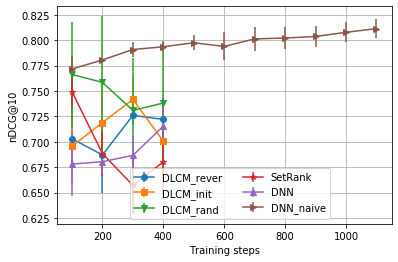

In [73]:
data_name="Toy"
baseline=["DLCM_rever","DLCM_init","DLCM_rand","SetRank","DNN","DNN_naive"]
propensity=np.array([0.68, 0.61, 0.48, 0.34, 0.28, 0.2, 0.11, 0.1, 0.08, 0.06])
data=np.load("result_log/"+data_name+"_DNN/eta_1.0/dla_e/train_log_raw.npz")
dla_mse=extract_mse(data,propensity)
Yahoo_data=process("result_log/"+data_name+"_DNN/eta_1.0")[0]["eta_1.0"]["dla_e"]
Yahoo_baseline=["result_log/"+data_name+"_"+i+"/eta_1.0" for i in baseline]
metrics=["err_3","ndcg_3","err_10","ndcg_10"]
results=[]
for ind,method in enumerate(Yahoo_baseline):
    print(method)
    data=process(method)[0]["eta_1.0"]["dla_e"]
    results_cur=[]
    for metric in metrics:
        data_cur=np.array(data[metric])
        data_base=np.array(Yahoo_data[metric])
#         print(data_cur,data_base)
        label="+" if np.mean(data_cur)>np.mean(data_base) else "-"
        size=np.min([data_cur.shape[0],data_base.shape[0]])
        p=stats.ttest_rel(data_cur[:size],data_base[:size])[1]
        result_cur_metric="{:#.3g}".format(np.mean(data_cur))
        if p<0.05:
            result_cur_metric+=label
#         print(np.mean(data_cur),p)
        results_cur.append(result_cur_metric)
    if "naive" not in method:
        data_mse=np.load(method+"/dla_e/train_log_raw.npz")
        mse=extract_mse(data_mse,propensity,dla_mse)
        results_cur.append(mse)
    else:
        results_cur.append("-")
    results.append(results_cur)
dfObj = pd.DataFrame(results, columns = metrics+["$MSE_{propen}$"], index=baseline)
dfObj.to_csv("plots/"+data_name+"_table.csv")
fig, ax = plt.subplots()
marker=["o","s","v","*","^",">","<"]
for ind,method in enumerate(Yahoo_baseline):
    data=np.load(method+"/dla_e/valid_log_raw.npz")
    steps=data["steps"]
    ndcg_mean=np.mean(data["ndcg_10"],1)
    ndcg_std=np.std(data["ndcg_10"],1)
    ax.errorbar(steps,ndcg_mean,ndcg_std,marker=marker[ind],label=baseline[ind])
# plt.xticks(np.arange(min(ind1), max(ind1)+1000, 1000))
leg = ax.legend(bbox_to_anchor=(0.33, 0.0, 0.5, 0.5),loc=4,ncol=2)
plt.xlabel('Training steps', fontsize=10)
plt.ylabel('nDCG@10', fontsize=10)
ax.yaxis.grid()
ax.xaxis.grid()
# plt.savefig("/raid/taoyang/research/research_everyday/homework/intro_to_ir/projects/experiment_log/pic/Istella_comparison.pdf",bbox_inches='tight')
plt.savefig("plots/"+data_name+"_comparison.pdf",bbox_inches='tight', dpi = 600)


## For， Yahoo data.

In [71]:
data_name="Yahoo"
baseline=["DLCM_rever","DLCM_init","DLCM_rand","SetRank","DNN","DNN_naive"]
propensity=np.array([0.68, 0.61, 0.48, 0.34, 0.28, 0.2, 0.11, 0.1, 0.08, 0.06])
data=np.load("result_log/"+data_name+"_DNN/eta_1.0/dla_e/train_log_raw.npz")
dla_mse=extract_mse(data,propensity)
Yahoo_data=process("result_log/"+data_name+"_DNN/eta_1.0")[0]["eta_1.0"]["dla_e"]
Yahoo_baseline=["result_log/"+data_name+"_"+i+"/eta_1.0" for i in baseline]
metrics=["err_3","ndcg_3","err_10","ndcg_10"]
results=[]
for ind,method in enumerate(Yahoo_baseline):
    print(method)
    data=process(method)[0]["eta_1.0"]["dla_e"]
    results_cur=[]
    for metric in metrics:
        data_cur=np.array(data[metric])
        data_base=np.array(Yahoo_data[metric])
#         print(data_cur,data_base)
        label="+" if np.mean(data_cur)>np.mean(data_base) else "-"
        size=np.min([data_cur.shape[0],data_base.shape[0]])
        p=stats.ttest_rel(data_cur[:size],data_base[:size])[1]
        result_cur_metric="{:#.3g}".format(np.mean(data_cur))
        if p<0.05:
            result_cur_metric+=label
#         print(np.mean(data_cur),p)
        results_cur.append(result_cur_metric)
    if "naive" not in method:
        data_mse=np.load(method+"/dla_e/train_log_raw.npz")
        mse=extract_mse(data_mse,propensity,dla_mse)
        results_cur.append(mse)
    else:
        results_cur.append("-")
    results.append(results_cur)
dfObj = pd.DataFrame(results, columns = metrics+["$MSE_{propen}$"], index=baseline)
dfObj.to_csv("plots/"+data_name+"_table.csv")
fig, ax = plt.subplots()
marker=["o","s","v","*","^",">","<"]
for ind,method in enumerate(Yahoo_baseline):
    data=np.load(method+"/dla_e/valid_log_raw.npz")
    steps=data["steps"]
    ndcg_mean=np.mean(data["ndcg_10"],1)
    ndcg_std=np.std(data["ndcg_10"],1)
    ax.errorbar(steps,ndcg_mean,ndcg_std,marker=marker[ind],label=baseline[ind])
# plt.xticks(np.arange(min(ind1), max(ind1)+1000, 1000))
leg = ax.legend(bbox_to_anchor=(0.33, 0.0, 0.5, 0.5),loc=4,ncol=2)
plt.xlabel('Training steps', fontsize=10)
plt.ylabel('nDCG@10', fontsize=10)
ax.yaxis.grid()
ax.xaxis.grid()
# plt.savefig("/raid/taoyang/research/research_everyday/homework/intro_to_ir/projects/experiment_log/pic/Istella_comparison.pdf",bbox_inches='tight')
plt.savefig("plots/"+data_name+"_comparison.pdf",bbox_inches='tight', dpi = 600)


## For， Istella-s data.

In [72]:
data_name="Istella"
baseline=["DLCM_rever","DLCM_init","DLCM_rand","SetRank","DNN","DNN_naive"]
propensity=np.array([0.68, 0.61, 0.48, 0.34, 0.28, 0.2, 0.11, 0.1, 0.08, 0.06])
data=np.load("result_log/"+data_name+"_DNN/eta_1.0/dla_e/train_log_raw.npz")
dla_mse=extract_mse(data,propensity)
Yahoo_data=process("result_log/"+data_name+"_DNN/eta_1.0")[0]["eta_1.0"]["dla_e"]
Yahoo_baseline=["result_log/"+data_name+"_"+i+"/eta_1.0" for i in baseline]
metrics=["err_3","ndcg_3","err_10","ndcg_10"]
results=[]
for ind,method in enumerate(Yahoo_baseline):
    print(method)
    data=process(method)[0]["eta_1.0"]["dla_e"]
    results_cur=[]
    for metric in metrics:
        data_cur=np.array(data[metric])
        data_base=np.array(Yahoo_data[metric])
#         print(data_cur,data_base)
        label="+" if np.mean(data_cur)>np.mean(data_base) else "-"
        size=np.min([data_cur.shape[0],data_base.shape[0]])
        p=stats.ttest_rel(data_cur[:size],data_base[:size])[1]
        result_cur_metric="{:#.3g}".format(np.mean(data_cur))
        if p<0.05:
            result_cur_metric+=label
#         print(np.mean(data_cur),p)
        results_cur.append(result_cur_metric)
    if "naive" not in method:
        data_mse=np.load(method+"/dla_e/train_log_raw.npz")
        mse=extract_mse(data_mse,propensity,dla_mse)
        results_cur.append(mse)
    else:
        results_cur.append("-")
    results.append(results_cur)
dfObj = pd.DataFrame(results, columns = metrics+["$MSE_{propen}$"], index=baseline)
dfObj.to_csv("plots/"+data_name+"_table.csv")
fig, ax = plt.subplots()
marker=["o","s","v","*","^",">","<"]
for ind,method in enumerate(Yahoo_baseline):
    data=np.load(method+"/dla_e/valid_log_raw.npz")
    steps=data["steps"]
    ndcg_mean=np.mean(data["ndcg_10"],1)
    ndcg_std=np.std(data["ndcg_10"],1)
    ax.errorbar(steps,ndcg_mean,ndcg_std,marker=marker[ind],label=baseline[ind])
# plt.xticks(np.arange(min(ind1), max(ind1)+1000, 1000))
leg = ax.legend(bbox_to_anchor=(0.33, 0.0, 0.5, 0.5),loc=4,ncol=2)
plt.xlabel('Training steps', fontsize=10)
plt.ylabel('nDCG@10', fontsize=10)
ax.yaxis.grid()
ax.xaxis.grid()
# plt.savefig("/raid/taoyang/research/research_everyday/homework/intro_to_ir/projects/experiment_log/pic/Istella_comparison.pdf",bbox_inches='tight')
plt.savefig("plots/"+data_name+"_comparison.pdf",bbox_inches='tight', dpi = 600)


# Analysis of Multivariate Scoring Functions for Automatic Unbiased earning to Rank
In this repository, we have uploaded the code corresponding to the CIKM2020 Paper "Analysis of Multivariate Scoring Functions for Automatic Unbiased Learning to Rank", which is also on arxiv (https://arxiv.org/abs/2008.09061).

You may play with toy data we prepared by run the following command line.
1. ./All_experiment.sh 

For Yahoo and Istella-s datasets, you need to prepare them in TREC form first.The Paper contains 2 figures and 2 tables. You can reproduce all of them.
steps:
1. git clone https://github.com/ULTR-Community/ULTRA.git
2. Prepare Yahoo and Istella-s acoording to pipelines in  ULTRA/example/Istella-S and ULTRA/example/Yahoo
3. Copy the tmp_data folder from step 2 to datasets. The structure should be like datasets/toy_data.
4. Uncomment corresponding part in All_experiment.sh
5. Open demo.ipynb for plotting.
